In [74]:
#Transfer Learnign Model Keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import backend as K
import numpy as np


In [75]:
img_width, img_height = 32, 32

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'C:/Users/dm12505/Desktop/val'
validation_data_dir = 'C:/Users/dm12505/Desktop/val'
nb_train_samples = 6
nb_validation_samples = 6
epochs = 50
batch_size = 1
test_dir = 'C:/Users/dm12505/Desktop/test1'
nb_test_samples = 6
test_batch_size = 1


In [76]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [77]:
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [78]:
# reading in image data from training and validation steps 

# use ImageDataGenerator to normalize/augment 

datagen = ImageDataGenerator(rescale=1. / 255)

# use flow_from_directory method to resize/pre-process 

generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

#use model predict to create bottleneck weights from VGG16 & save to .npy file

bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

generator = datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_test = model.predict_generator(
        generator, nb_test_samples // batch_size)
np.save(open('bottleneck_features_test.npy', 'wb'), bottleneck_features_test)



Found 6 images belonging to 2 classes.
Found 6 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [79]:
# train and create labels in sequential order

# cats 0; dogs 1 

train_data = np.load(open('bottleneck_features_train.npy','rb'))
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

test_data = np.load(open('bottleneck_features_test.npy','rb'))
test_labels = np.array([0] * (nb_test_samples // 2) + [1] * (nb_test_samples // 2))



In [80]:
print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(6, 1, 1, 512)
(6,)
(6, 1, 1, 512)
(6,)
(6, 1, 1, 512)
(6,)


In [81]:
# create dense fully connected model to add to base pre-configured model 
# inputs from trained bottled features

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________


In [82]:
# fit combined models to data

from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

predict = model.fit(train_data, train_labels,
             epochs=epochs,
             batch_size=batch_size,
             validation_data=(validation_data, validation_labels), callbacks=[checkpointer], verbose =2)


Train on 6 samples, validate on 6 samples
Epoch 1/50
 - 0s - loss: 0.7627 - acc: 0.8333 - val_loss: 0.4969 - val_acc: 0.8333

Epoch 00001: val_loss improved from inf to 0.49692, saving model to model.weights.best.hdf5
Epoch 2/50
 - 0s - loss: 0.5111 - acc: 0.8333 - val_loss: 0.3463 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.49692 to 0.34630, saving model to model.weights.best.hdf5
Epoch 3/50
 - 0s - loss: 0.3923 - acc: 0.8333 - val_loss: 0.2560 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.34630 to 0.25596, saving model to model.weights.best.hdf5
Epoch 4/50
 - 0s - loss: 0.2583 - acc: 1.0000 - val_loss: 0.1957 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.25596 to 0.19566, saving model to model.weights.best.hdf5
Epoch 5/50
 - 0s - loss: 0.2482 - acc: 1.0000 - val_loss: 0.1523 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.19566 to 0.15231, saving model to model.weights.best.hdf5
Epoch 6/50
 - 0s - loss: 0.1526 - acc: 1.0000 - val_loss: 0.11


Epoch 00046: val_loss improved from 0.00298 to 0.00285, saving model to model.weights.best.hdf5
Epoch 47/50
 - 0s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000

Epoch 00047: val_loss improved from 0.00285 to 0.00271, saving model to model.weights.best.hdf5
Epoch 48/50
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000

Epoch 00048: val_loss improved from 0.00271 to 0.00258, saving model to model.weights.best.hdf5
Epoch 49/50
 - 0s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000

Epoch 00049: val_loss improved from 0.00258 to 0.00248, saving model to model.weights.best.hdf5
Epoch 50/50
 - 0s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000

Epoch 00050: val_loss improved from 0.00248 to 0.00239, saving model to model.weights.best.hdf5


In [83]:
print(predict)

In [84]:
print(predict.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


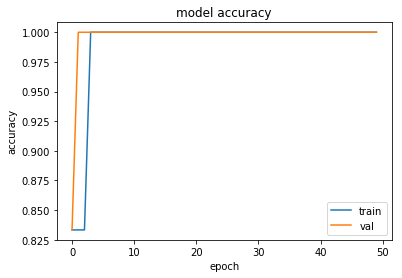

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

print(predict.history.keys())
plt.plot(predict.history['acc'])
plt.plot(predict.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [86]:
#load best trained weights

model.load_weights('model.weights.best.hdf5')

In [87]:

#use model predict to create bottleneck weights from VGG16 & save to .npy file

#test_labels = model.evaluate_generator(generator, steps=len(generator), workers=1, use_multiprocessing=False)

#probabilities = model.predict_generator(generator, 6)

#from sklearn.metrics import confusion_matrix

#y_true = np.array([0] * 1000 + [1] * 1000)
#y_pred = probabilities > 0.5

#confusion_matrix(y_true, y_pred)

score = model.evaluate(test_data, test_labels, verbose=1)
print('\n', 'Test accuracy:', score[1])


6/6 [==============================] - 0s 333us/step

 Test accuracy: 0.6666666865348816
